# Final Project AAI 530: Smoke Detector

## 1. Introduction

Many states in America require homes to have smoke detectors, as fire has caused thousands of deaths in the country. Between 2011 and 2019, fire-related deaths accounted for approximately 7% of the U.S. population [1]. Having a working and sensitive smoke detector can save lives.

Smoke detectors are not limited to homes; they can be used in manufacturing facilities, school buildings, and other locations.

Smoke detectors work by detecting particles in the air. There are two types of smoke detectors: ionization and photoelectric. Ionization detectors detect current reduction as particles get trapped between the two plates in the detector. Photoelectric detectors detect the amount of light bounce when there are no particles present and when there are particles present [2]. In this project, we analyze data from photoelectric smoke detectors.

Project goal: to build a model to predict the state of the alarm on or off using the window of sensor data preceding the prediction.

## 2. Data

The data used in this project is smoke detection dataset from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset)

The dataset features in detail:

* Air Temperature
* Air Humidity
* TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
* eCO2: co2 equivalent concentration; calculated from different values like TVCO
* Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
* Raw Ethanol: raw ethanol gas (Source)
* Air Pressure
* PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
* Fire Alarm: ground truth is "1" if a fire is there
* CNT: Sample counter
* UTC: Timestamp UTC seconds
* NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);

## 3. Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import seaborn as sb
from matplotlib.dates import DateFormatter
from statsmodels.graphics.gofplots import ProbPlot
#import statesmodels.api
from scipy import stats
import math
from mpl_toolkits import mplot3d
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import warnings

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
import random
from sklearn.metrics import mean_squared_error as mse
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Setting seed for reproducibility
np.random.seed(1234) 
PYTHONHASHSEED = 0
warnings.filterwarnings('ignore')

In [2]:
# First we load the data into a pandas df and do some initial discoveries
df_smoke_detection= pd.read_csv ("smoke_detection_iot.csv")
df_smoke_detection.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


We create a new column 'time_diff' and just increment the time difference 1 since we knew in this dataset, we have readings at a rate of 1Hz.

We will then convert our datetime column to something called unix/epoch time stored in a new column 'time'.

In [3]:
#convert datetime to epoch/unix time
df_smoke_detection['time_diff'] = 1
df_smoke_detection['time'] =df_smoke_detection.time_diff.cumsum()
# Delete columns with no significance
df_smoke_detection.pop('time_diff')
df_smoke_detection.pop('CNT')
df_smoke_detection.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,time
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,1
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,2
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,3
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,4
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,5


In [4]:
df_smoke_detection.dtypes

Unnamed: 0          int64
UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
Fire Alarm          int64
time                int64
dtype: object

In [5]:
#convert all int variables to float
df_smoke_detection['TVOC[ppb]']=df_smoke_detection['TVOC[ppb]'].astype('float64')
df_smoke_detection['eCO2[ppm]']=df_smoke_detection['eCO2[ppm]'].astype('float64')
df_smoke_detection['Raw H2']=df_smoke_detection['Raw H2'].astype('float64')
df_smoke_detection['Raw Ethanol']=df_smoke_detection['Raw Ethanol'].astype('float64')
df_smoke_detection['Fire Alarm']=df_smoke_detection['Fire Alarm'].astype('float64')
df_smoke_detection['time']=df_smoke_detection['time'].astype('float64')

df_smoke_detection.dtypes

Unnamed: 0          int64
UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]         float64
eCO2[ppm]         float64
Raw H2            float64
Raw Ethanol       float64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
Fire Alarm        float64
time              float64
dtype: object

In [6]:
df_smoke_detection.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,62630.0,3.131450e+04,18079.868017,0.000000e+00,1.565725e+04,3.131450e+04,4.697175e+04,6.262900e+04
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04


This table provides overall data landscape in terms of data distribution.

## 3. Data Exploration

### 3.a. Missing & Duplicate Data

In [7]:
#Check data shape
df_smoke_detection.shape

(62630, 16)

In [8]:
# Check for missing data
df_smoke_detection.isna().sum()

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
time              0
dtype: int64

In [9]:
# Check for null values
df_smoke_detection.isnull().values.any()

False

In [10]:
# Check for duplicates
df_smoke_detection.duplicated().sum()

0

### Correlation

In [11]:
df_smoke_detection.corr()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,time
Unnamed: 0,1.000000,0.551987,0.425636,-0.498121,0.248813,0.160665,-0.232854,0.083094,-0.580829,0.151785,0.128487,0.162053,0.126418,0.100300,-0.361351,1.000000
UTC,0.551987,1.000000,-0.164174,-0.391907,0.180731,0.132100,-0.151088,0.166555,-0.434375,0.123168,0.105304,0.130288,0.103695,0.083234,-0.389404,0.551987
Temperature[C],0.425636,-0.164174,1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.163902,0.425636
Humidity[%],-0.498121,-0.391907,-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.399846,-0.498121
TVOC[ppb],0.248813,0.180731,0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.214743,0.248813
eCO2[ppm],0.160665,0.132100,0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.097006,0.160665
Raw H2,-0.232854,-0.151088,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,0.107007,-0.232854
Raw Ethanol,0.083094,0.166555,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.340652,0.083094
Pressure[hPa],-0.580829,-0.434375,-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.249797,-0.580829
PM1.0,0.151785,0.123168,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.110552,0.151785


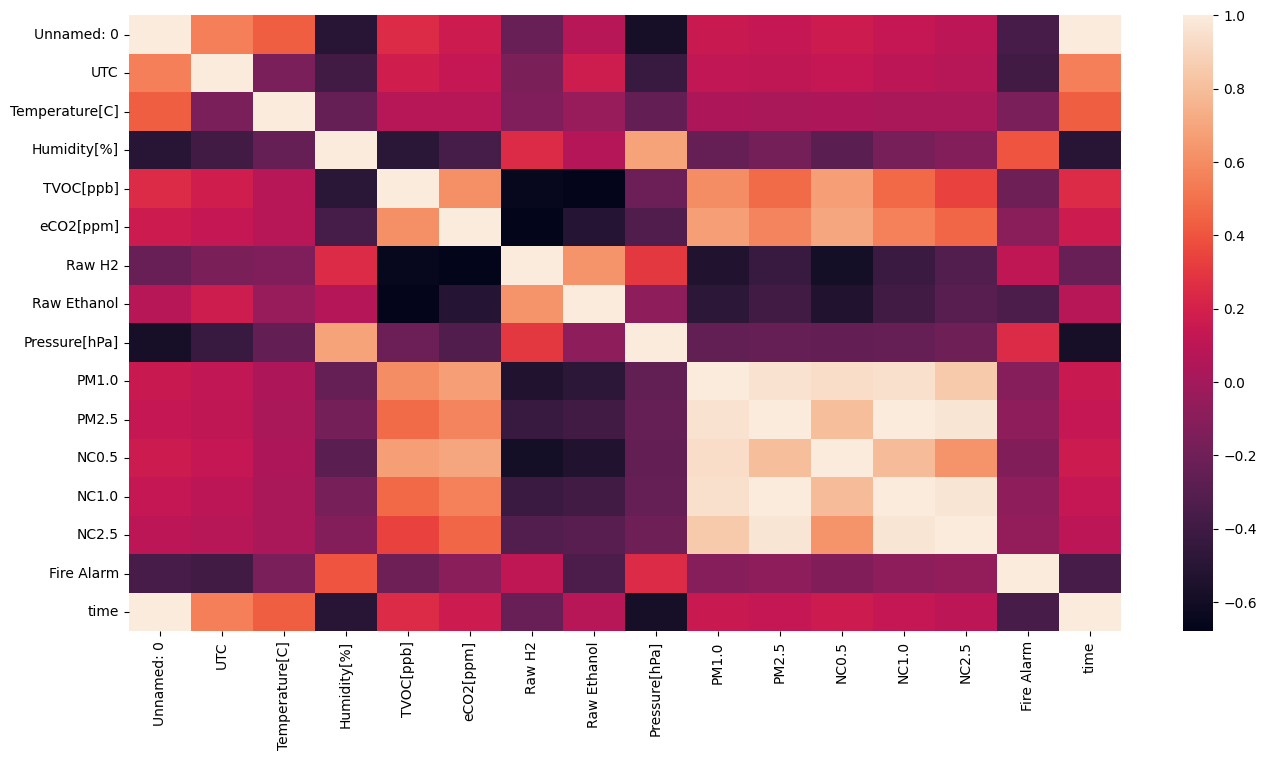

In [13]:
# create a heatmap to visualize the correlation between the different variables and the target(Fire Alarm)
plt.figure(figsize=(16,8))
matrix_map=round(df_smoke_detection.corr(),2)
sns.heatmap(matrix_map);

PM1, PM 2.5, NC 0.5, NC1 and NC 2.5 are highly correlated. Therefore, including one from each categtory is good enough. eCO2 has a moderate negative correlation to the Raw H2 content, and positive correlation with TVOC which will help predict the Carbon Dioxide content.

<AxesSubplot: >

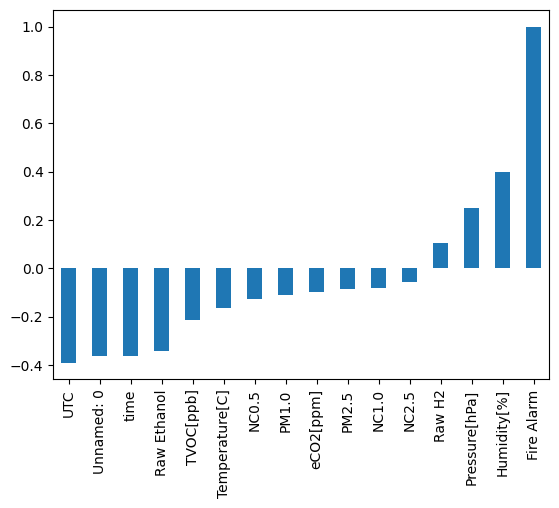

In [14]:
df_smoke_detection.corr()['Fire Alarm'].sort_values().plot(kind='bar')

### Variance Inflation Factor (VIF)

In [17]:
#Calculating VIF
vif_df = pd.DataFrame()
vif_df['variable'] = df_smoke_detection.columns 

#VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(df_smoke_detection.values, i) for i in range(df_smoke_detection.shape[1])]

#VIF for each predictor variable 
sorted_vif_df = vif_df.sort_values(by='VIF', ascending=False)
sorted_vif_df

,variable,VIF
0,Unnamed: 0,inf
15,time,inf
12,NC1.0,1.683589e+12
13,NC2.5,6.668542e+11
10,PM2.5,4.599264e+11
9,PM1.0,9.728153e+10
11,NC0.5,7.369239e+10
7,Raw Ethanol,5.068904e+00
4,TVOC[ppb],4.806921e+00
3,Humidity[%],3.490363e+00


* VIF = 1: There is no correlation between the predicted variable and predictor variables.
* VIF between 1 and 5: There is moderate correlation between the predicted variable and other predictor variables.
* VIF > 5: There is severe correlation between a given predicted variable and other predictor variables in the model.
* Conclusion: NCs, PMs and UTC are highly correlated as seen in the heatmap
* *Note: &nbsp; analysis based on "How to Test for Multicollinearity in Python" by Zach [3].

### Data Distribution

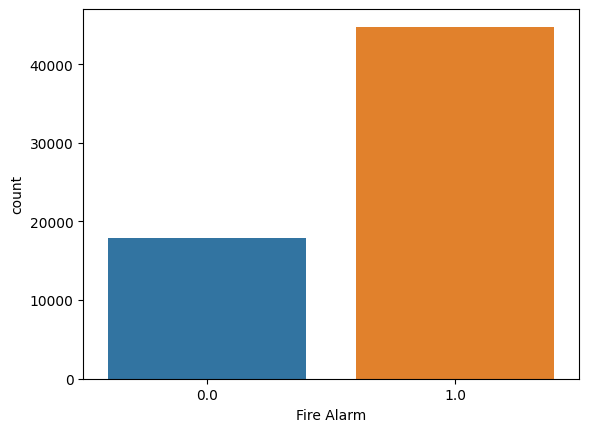

In [18]:
g=sns.countplot(x = df_smoke_detection["Fire Alarm"])
plt.show()

Fire Alarm: ground truth is "1" if a fire is there and "0" if no fire is there.

So data with fire alarm went off is close to half of data without fire alarm went off. We may have class imbalance in our data. Future work could be done to balance the data. 

### Data Insights

Anomaly detection refers to the process of identifying unusual patterns or observations in your data that deviate from the expected behavior. In the context of time series data from a smoke detector, we can use anomaly detection techniques to identify abnormal readings from the sensors that may indicate a potential fire.

Potential indicators:
Abnormal readings in temperature or humidity sensors.
Abnormal readings in the levels of smoke or carbon monoxide in the air.
An increase in the frequency of false alarms.
An unexpected change in the pattern of sensor readings.
An outlier in the readings from one or more sensors.

By detecting these anomalies, the smoke detector makes sound to alert users and prevent a fire from occurring.

To build a model that gives prediction about the accuracy of the alarm, we explore the data to understand the relationship between the features and the prediction.

Since the data is highly imbalanced, the model we build will likely predict 1 for Fire Alarm than 0.

## Data Visualization

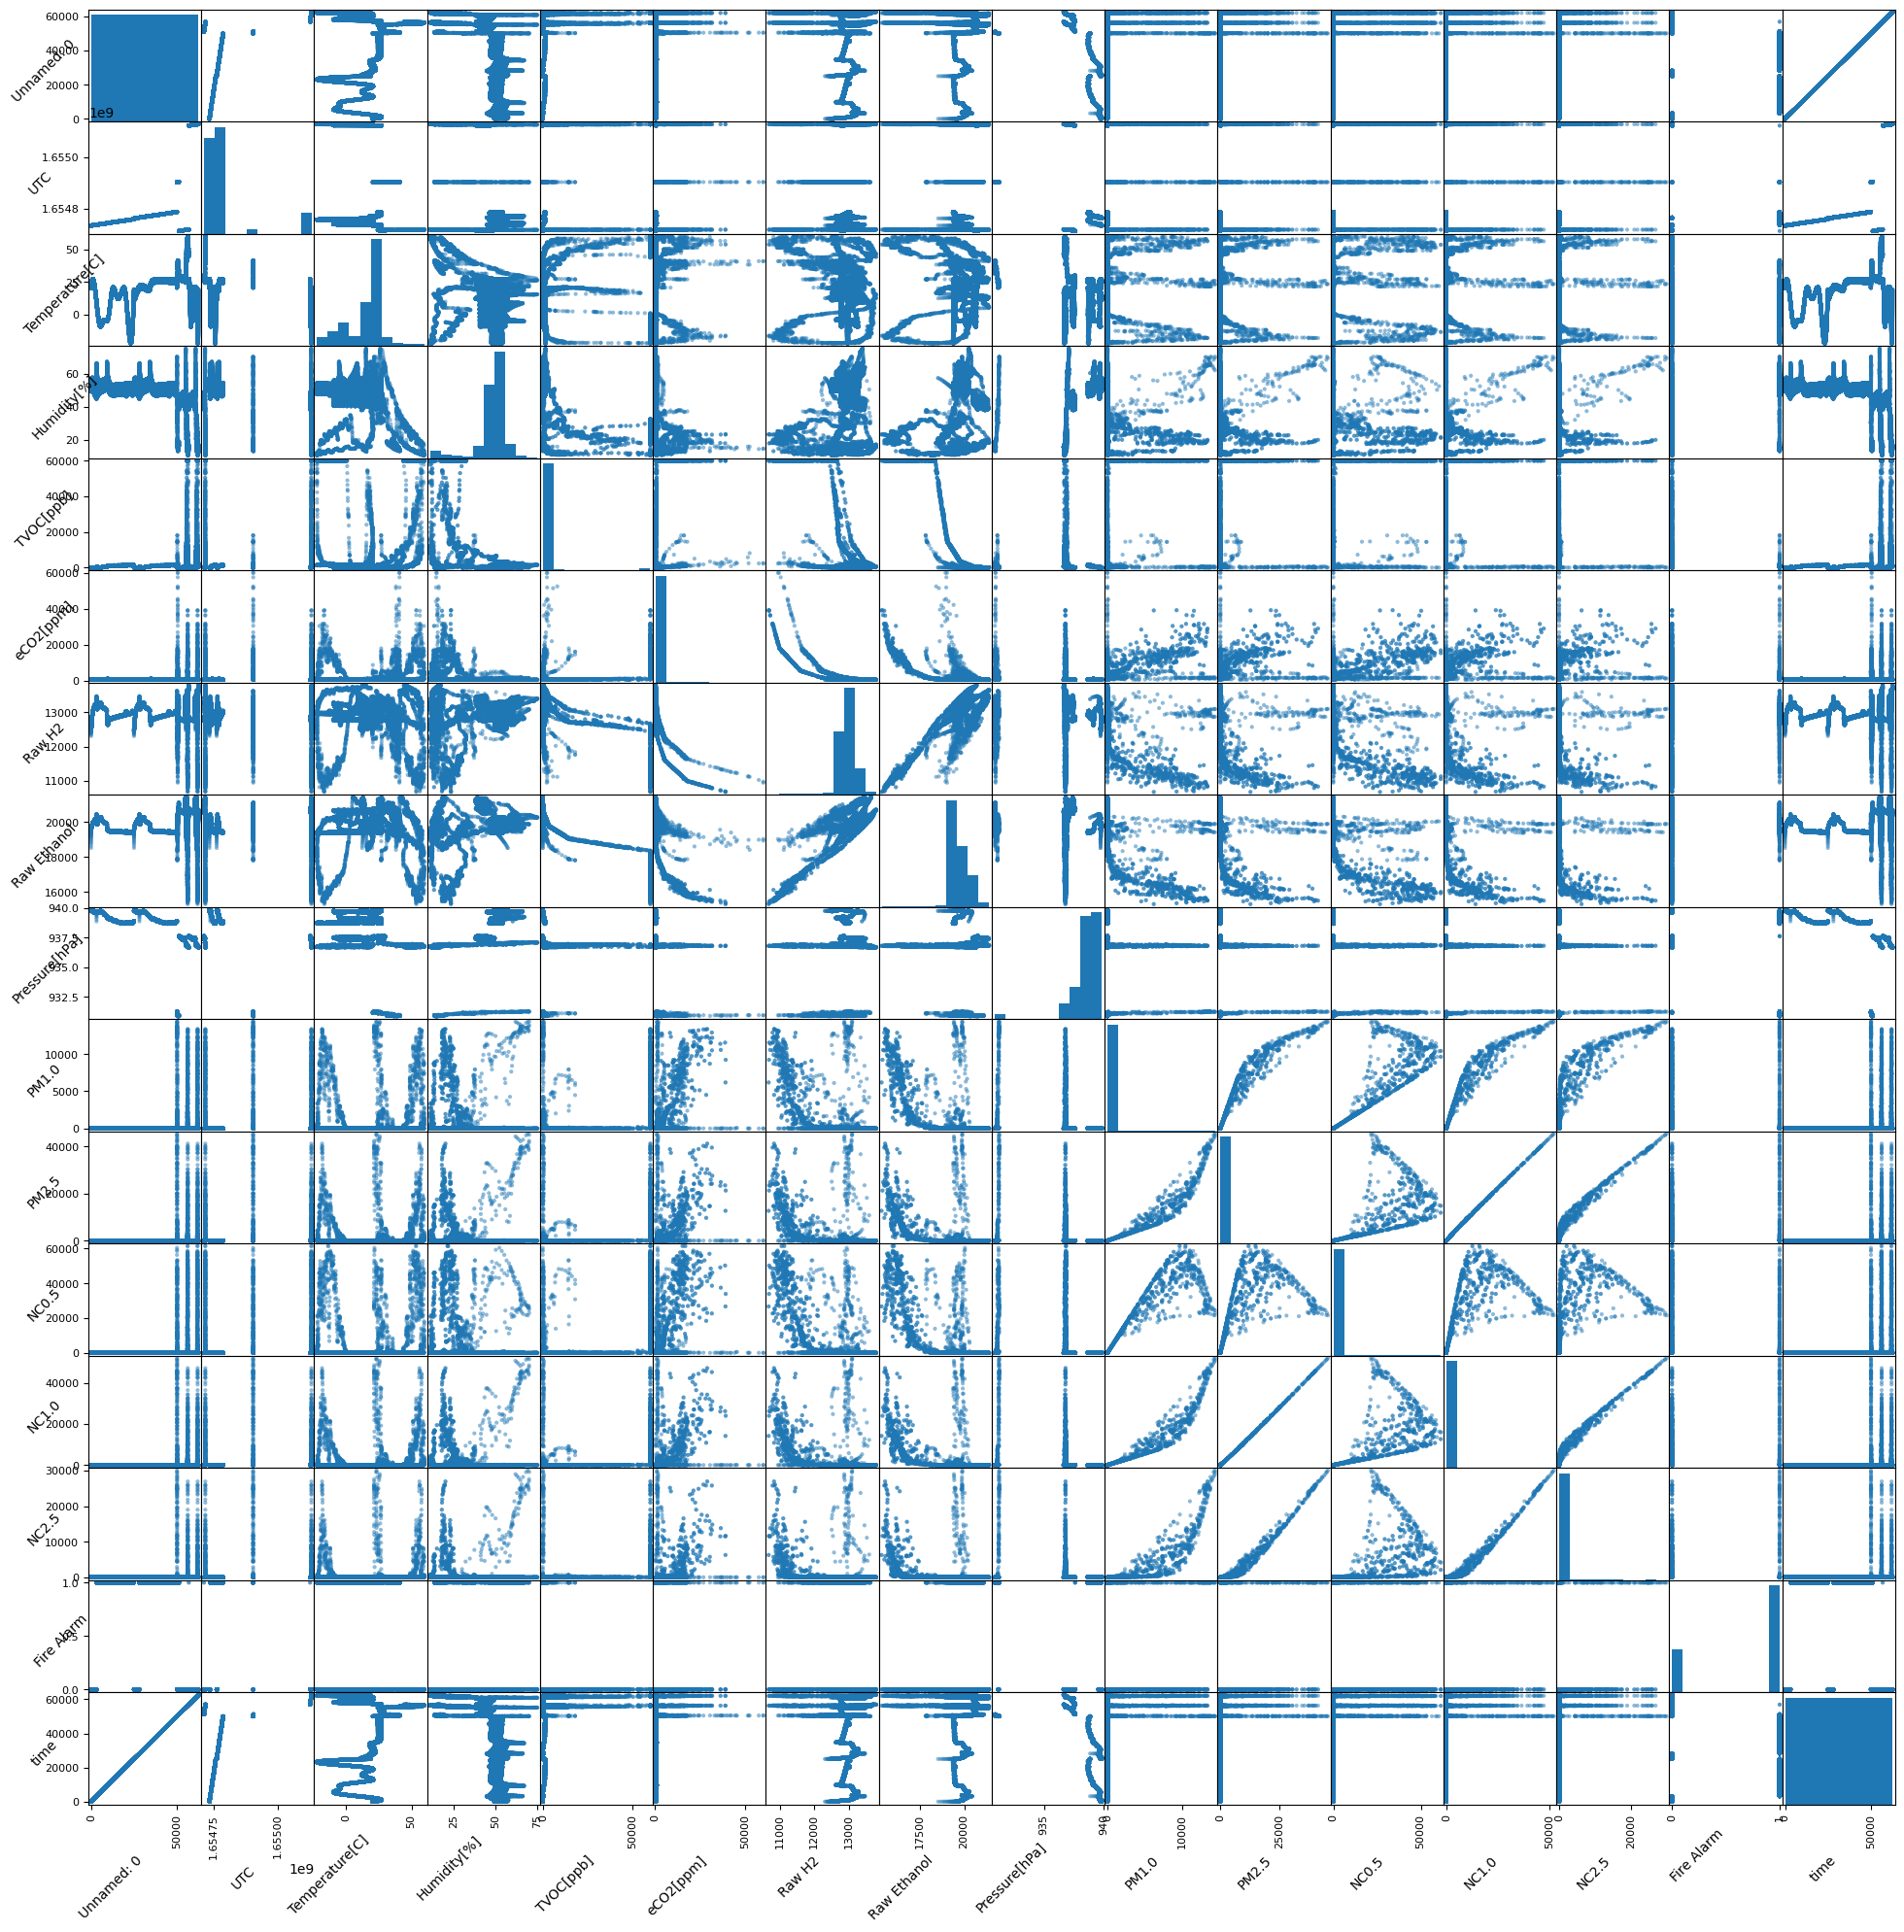

In [19]:
#Scatter Plot
scatter_matrix = pd.plotting.scatter_matrix(df_smoke_detection, figsize  = [24, 24]);

# Rotate the x-axis and y-axis labels by 45 degrees
for ax in scatter_matrix.ravel():
    # Rotate x-axis labels
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    
    # Rotate y-axis labels
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_va('top')

In [20]:
# Let y be the Fire Alarm outcome (1:yes, 0:no)
# Let x be the features
y = df_smoke_detection['Fire Alarm']
x = df_smoke_detection.drop(['Fire Alarm'], axis =1)

In [21]:
column_list = []
for i in df_smoke_detection.columns:
    column_list.append(i)
features = column_list[:-1]
features

['Unnamed: 0',
 'UTC',
 'Temperature[C]',
 'Humidity[%]',
 'TVOC[ppb]',
 'eCO2[ppm]',
 'Raw H2',
 'Raw Ethanol',
 'Pressure[hPa]',
 'PM1.0',
 'PM2.5',
 'NC0.5',
 'NC1.0',
 'NC2.5',
 'Fire Alarm']

Unnamed: 0


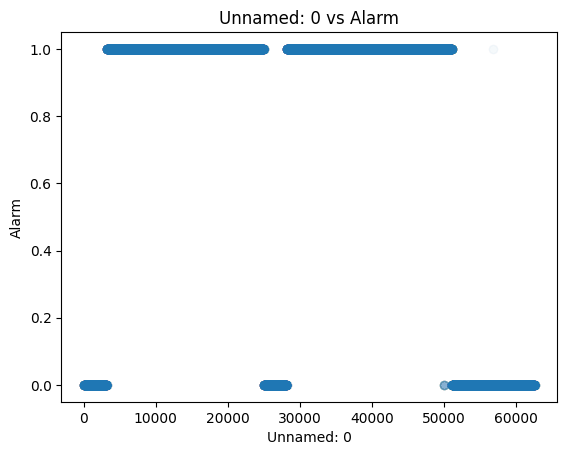

UTC


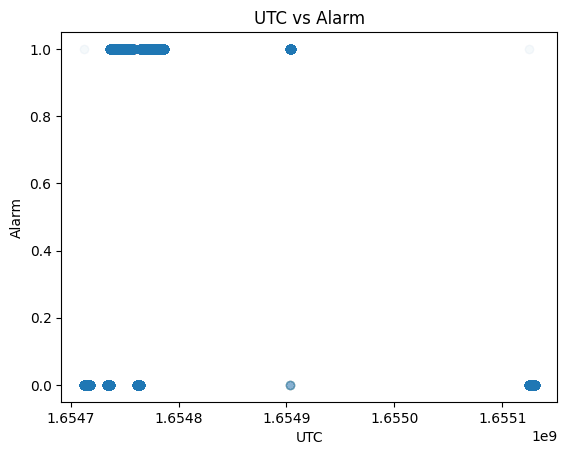

Temperature[C]


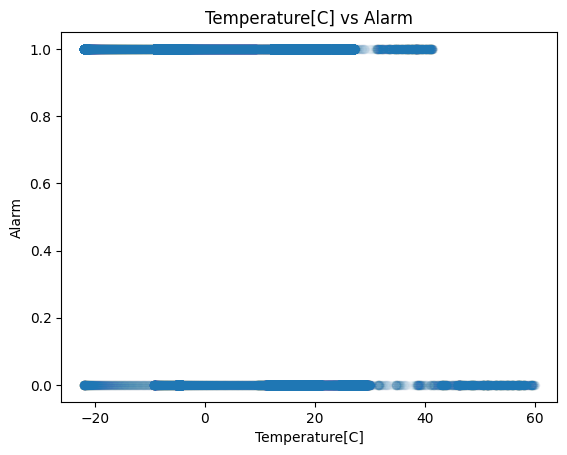

Humidity[%]


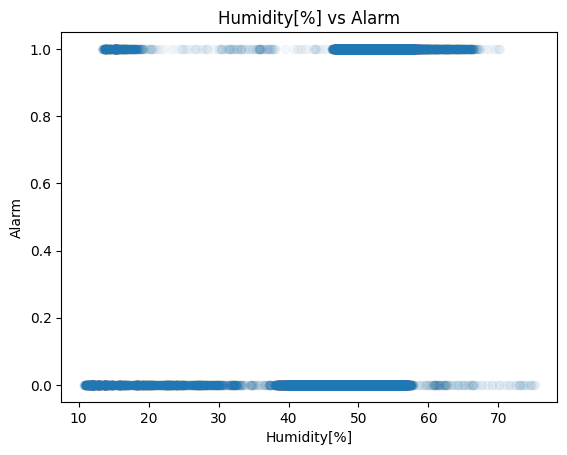

TVOC[ppb]


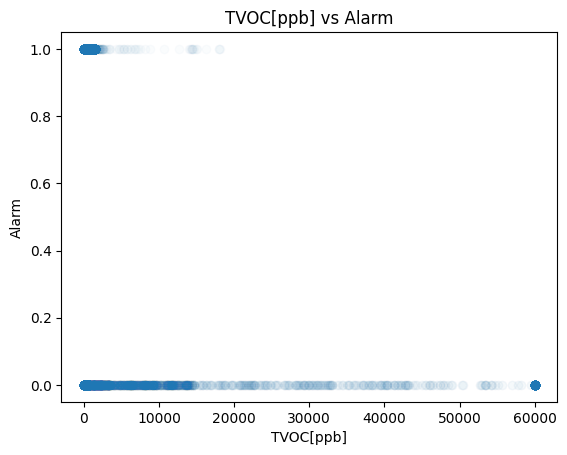

eCO2[ppm]


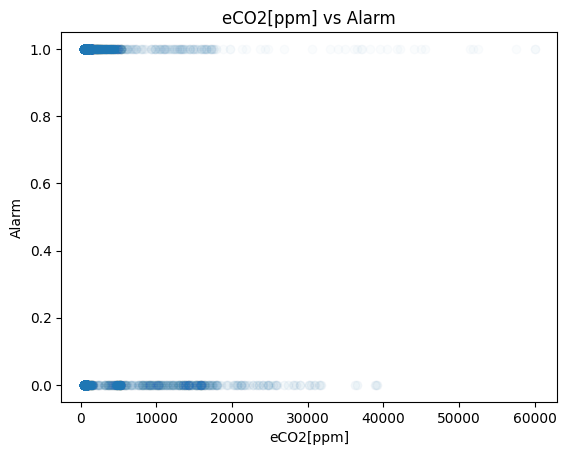

Raw H2


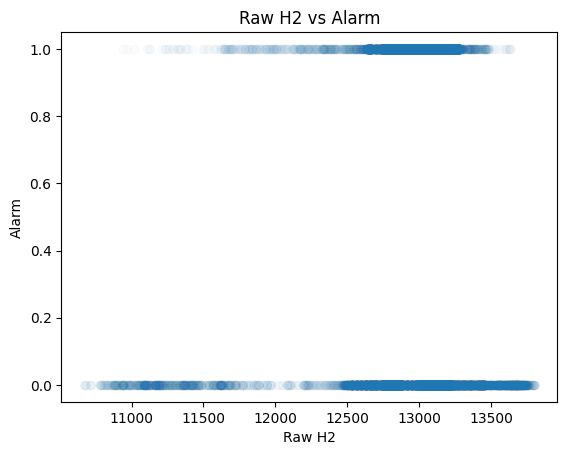

Raw Ethanol


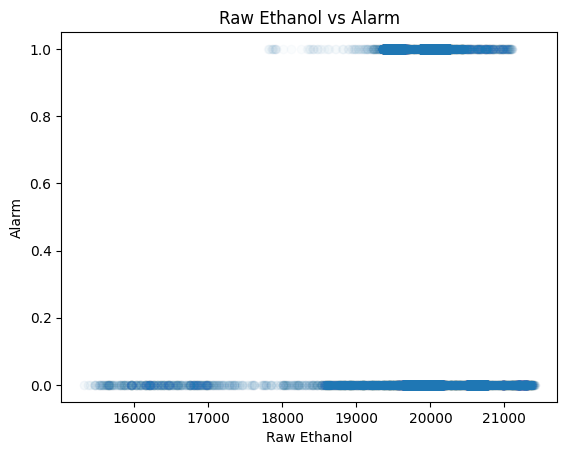

Pressure[hPa]


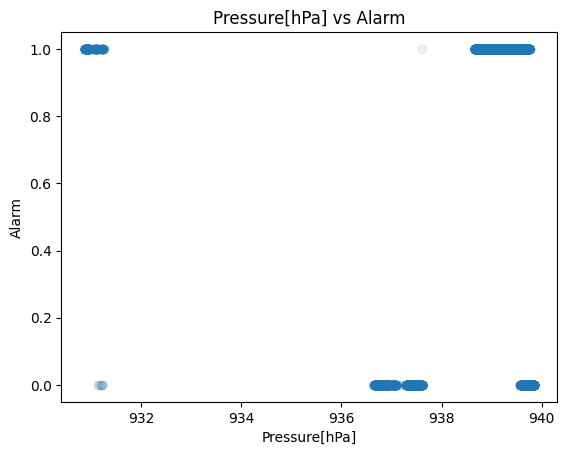

PM1.0


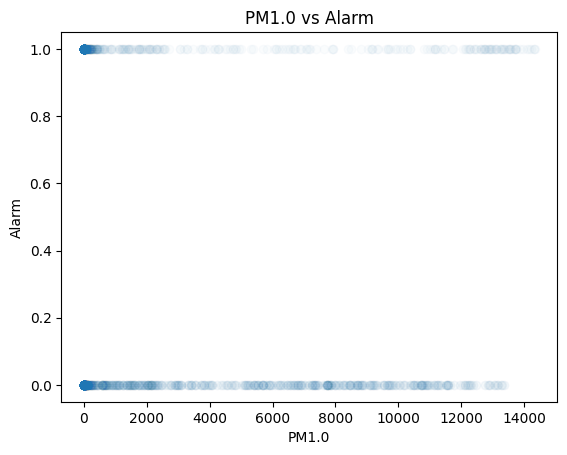

PM2.5


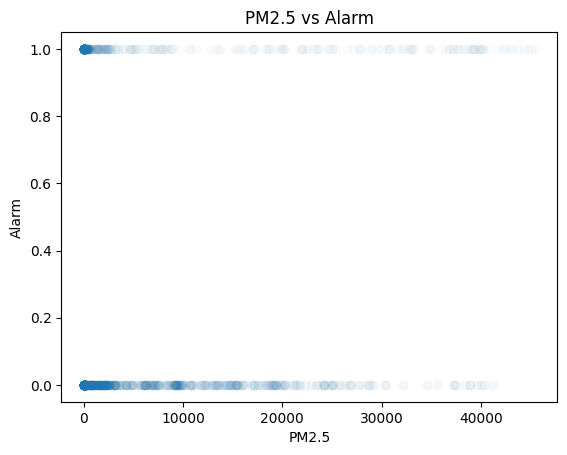

NC0.5


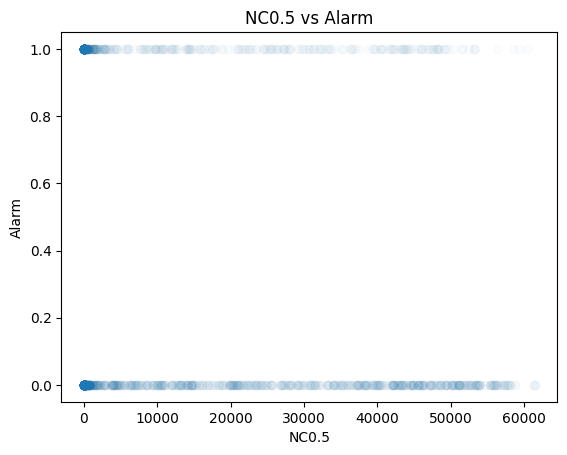

NC1.0


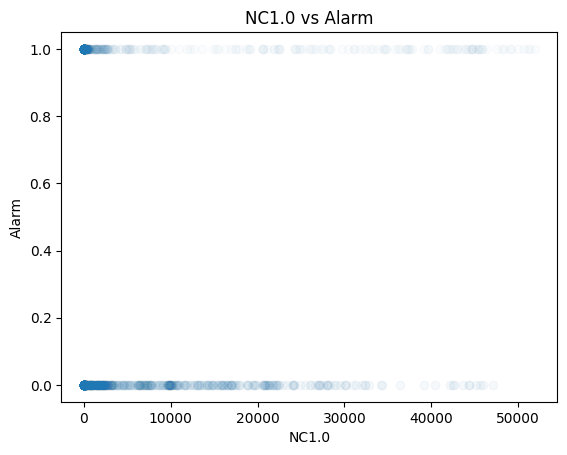

NC2.5


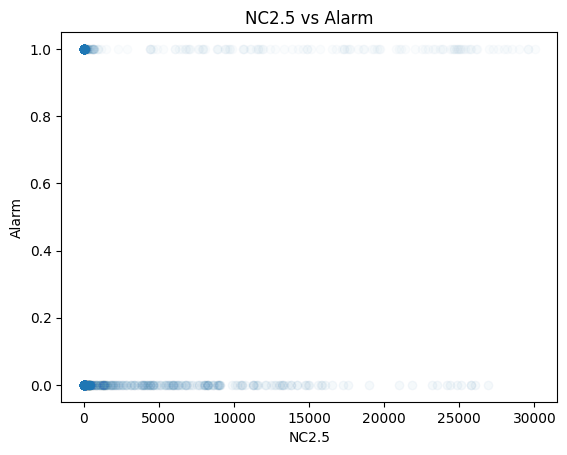

Fire Alarm


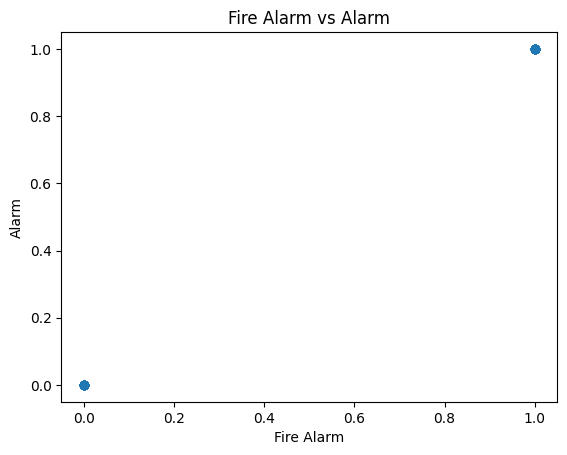

In [23]:
for feature in features:
    print(feature)
    plt.scatter(df_smoke_detection[feature], y, alpha=0.02)
    plt.title(feature + " vs Alarm")
    plt.xlabel(feature)
    plt.ylabel("Alarm")
    plt.show()

Note: expecting to see a clear cutoff between some of the features vs alarm on or off. For instance, positive smoke detection for ethanol over 19000. Some data did not give a clear cutoff. Most likely, more than one factors are used to determine when the alarm goes off or not.

UTC


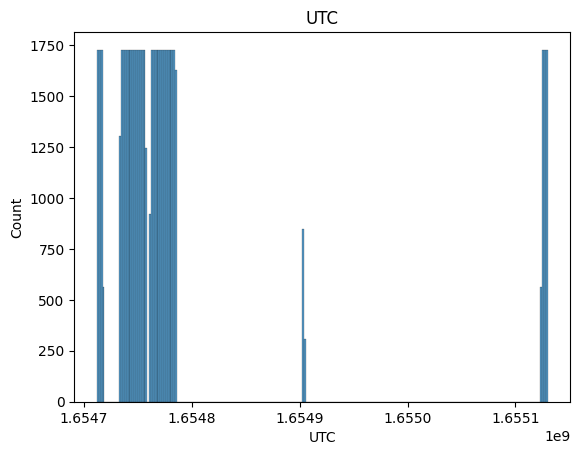

Temperature[C]


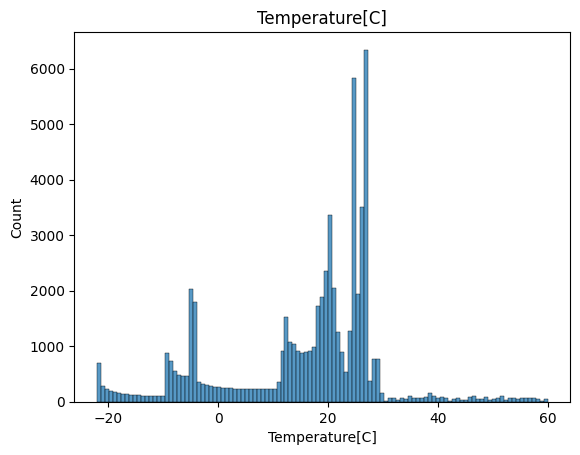

Humidity[%]


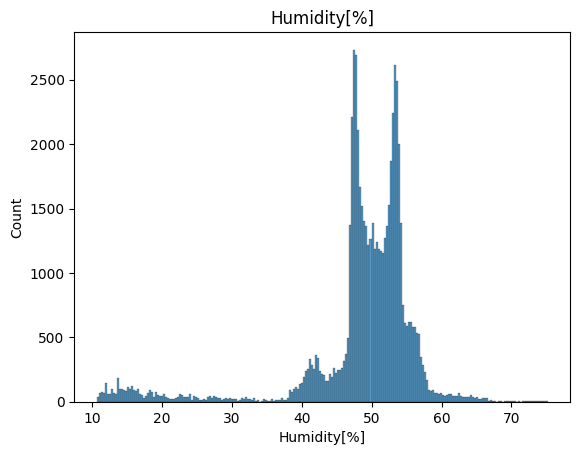

TVOC[ppb]


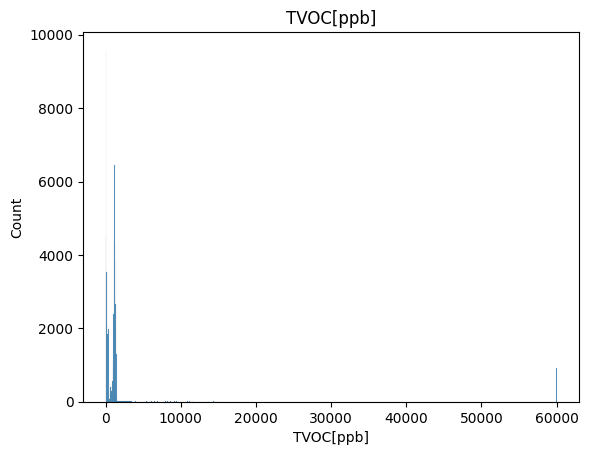

Raw H2


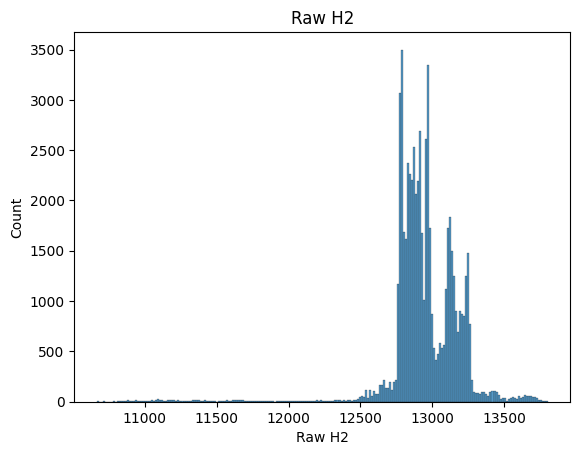

Raw Ethanol


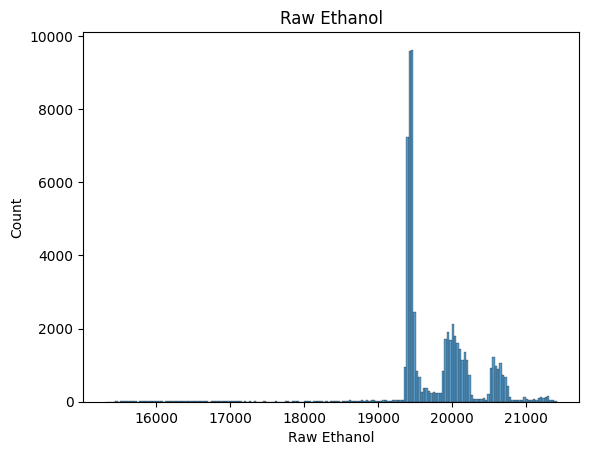

Pressure[hPa]


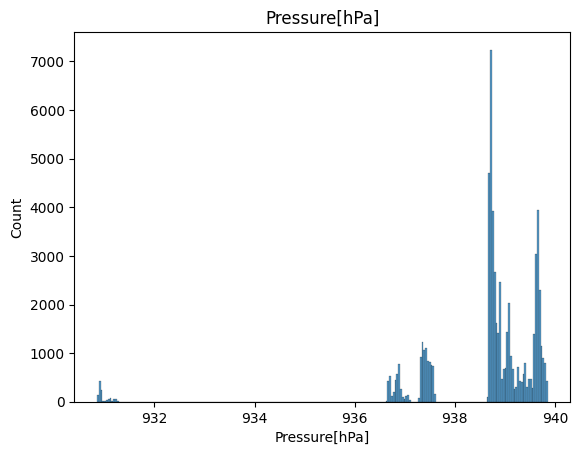

In [25]:
# Histograms for features of interest
features_for_plotting = ['UTC','Temperature[C]','Humidity[%]','TVOC[ppb]','Raw H2','Raw Ethanol','Pressure[hPa]']
for feature in features_for_plotting:
    print(feature)
    df_tmp = df_smoke_detection.set_index(feature)
    sns.histplot(df_smoke_detection[feature])
    plt.title(feature)
    plt.xlabel(feature)
    plt.show()

# 5. Machine Learning Model

# 5.a. Linear Regression

We use TVOC, Raw H2, and NC0.5 to predict eCo2 which is supposed to increase in the incident of fire.

In [26]:
#Extracting a subset of the data associated with the columns in 'attributes' and assign it to the variable x.
attributes= ['TVOC[ppb]', 'Raw H2', 'NC0.5']
x=df_smoke_detection[attributes]
#Extract the subset  with 'eCO2[ppm]' column, and assign it to the variable y.
y=df_smoke_detection['eCO2[ppm]']
x.head()

,TVOC[ppb],Raw H2,NC0.5
0,0.0,12306.0,0.0
1,0.0,12345.0,0.0
2,0.0,12374.0,0.0
3,0.0,12390.0,0.0
4,0.0,12403.0,0.0


In [27]:
# Normalization of the attributes
cols_to_scale=['TVOC[ppb]', 'Raw H2', 'NC0.5']
scaler = StandardScaler().fit(x[cols_to_scale])
x_scaled = pd.DataFrame(scaler.fit_transform(x[cols_to_scale]), columns = x[cols_to_scale].columns, index = x[cols_to_scale].index)
print(np.mean(x_scaled, axis=0))
print(np.std(x_scaled, axis=0))
x[cols_to_scale]= x_scaled
x_scaled.head()

TVOC[ppb]    0.000000e+00
Raw H2      -3.412602e-16
NC0.5        7.260855e-18
dtype: float64
TVOC[ppb]    1.0
Raw H2       1.0
NC0.5        1.0
dtype: float64


,TVOC[ppb],Raw H2,NC0.5
0,-0.248614,-2.335935,-0.115215
1,-0.248614,-2.192796,-0.115215
2,-0.248614,-2.086359,-0.115215
3,-0.248614,-2.027636,-0.115215
4,-0.248614,-1.979923,-0.115215


In [28]:
#convert the dataframes into numpy arrays
x_arr = x_scaled.to_numpy()
y_arr = y.to_numpy()

In [29]:
#Print the shape of both x and y
print("Shape of x=", x_scaled.shape)
print("Shape of y=", y.shape)

Shape of x= (62630, 3)
Shape of y= (62630,)


# 5.b. Splitting Data into Train and Test

In [30]:
# use sklearn function train_test_split to split the dataset into 80% training and 20% testing sets 
# train_test_split returns 4 data subsets
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=0.20,shuffle=True)
# print the shapes of the returned arrays
print("x_train=", x_train.shape)
print("x_test=", x_test.shape)

x_train= (50104, 3)
x_test= (12526, 3)


In [31]:
# call the function linear Regression and assign variable clf to create a Linear Regression classifier
clf=LinearRegression()
# call fit method on clf with x_train and y_train
clf.fit(x_train,y_train)
# call predict on clf for a variable prediction
prediction=clf.predict(x_test)
print(type(prediction))
print(type(y_test))
Std_ytest=np.std(y_test)
Normalized_mse=mean_squared_error(y_test, prediction)
Normalized_mse=Normalized_mse/(Std_ytest)**2
# print The Noormalized MSE for the LR model
print("Normalized MSE=", Normalized_mse)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Normalized MSE= 0.46119630795500666


## 5c. Linear Regression Model

In [32]:
# Fit the linear regression model another way using statmodels to print the model summary 
# summary analysis and the different coefficients of the LR model 
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.552
Model:                            OLS   Adj. R-squared (uncentered):              0.552
Method:                 Least Squares   F-statistic:                          2.055e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):                        0.00
Time:                        23:11:07   Log-Likelihood:                     -4.3192e+05
No. Observations:               50104   AIC:                                  8.638e+05
Df Residuals:                   50101   BIC:                                  8.639e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
# save prediction to csv file
## convert your array into a dataframe
prediction  = pd.DataFrame (prediction)

## save to csv file

filepath = 'prediction_lr.csv'

prediction.to_csv(filepath, index=False)

# 5.d. Plotting the LR model

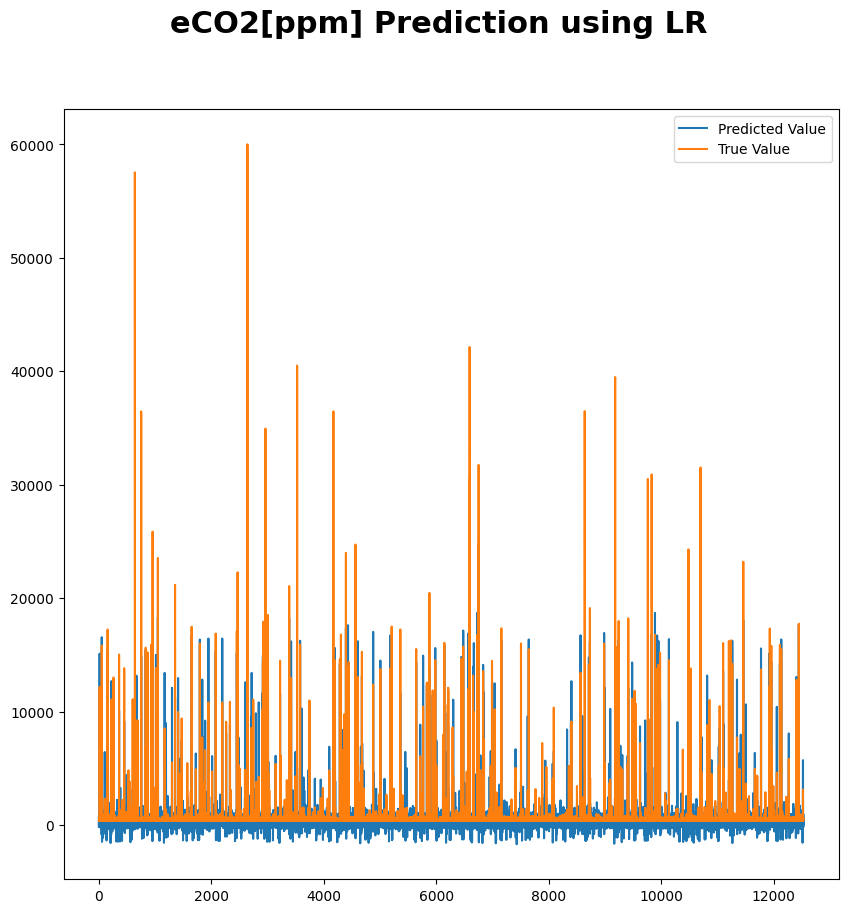

In [34]:
# plot of the eCO2[ppm] prediction
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('eCO2[ppm] Prediction using LR', fontsize=22, fontweight='bold')
ax.plot(prediction, label='Predicted Value')
ax.plot(y_test, label='True Value')
ax.legend()

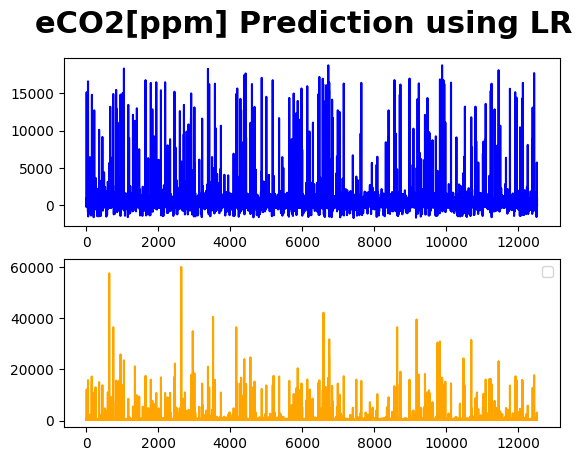

In [35]:
# Print subplots of the prediction for better visualization
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2)
figsize=(10,10)
fig.suptitle('eCO2[ppm] Prediction using LR', fontsize=22, fontweight='bold')
l1= axis[0].plot(prediction, label='Predicted', color='blue')
l2= axis[1].plot(y_test, label='True', color='orange')
plt.legend([l1, l2],['Predicted', 'True'], loc='upper right')
plt.show()

The linear regression model achieved a relativley good performence, with a low MSE value of 0.46

## Checking the balance in the Fire Alarm Data [Ones versus Zeros]

In [36]:
# selecting rows in Fire Alarm which have 1 value meaning, yes there is a Fire
df_smoke_detection_True = df_smoke_detection.loc[df_smoke_detection['Fire Alarm'] == 1]
# selecting rows in Fire Alarm which have 0 value meaning, No there is no Fire 
df_smoke_detection_False = df_smoke_detection.loc[df_smoke_detection['Fire Alarm'] == 0]
print("dataset size",df_smoke_detection.shape)
print("dataset size with True Fire Alarm",df_smoke_detection_True.shape)
print("dataset size with False Fire Alarm",df_smoke_detection_False.shape)

dataset size (62630, 16)
dataset size with True Fire Alarm (44757, 16)
dataset size with False Fire Alarm (17873, 16)


# 6. Deep Learning Model

# 6.a. LSTM time series model to predict the Fire Alarm

In [37]:
#Extract the subset of smoke_detection associated with the columns in 'attributes' and assign it to the variable x.
attributes2= ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'time']
x2=df_smoke_detection[attributes2]
#Extract the subset of smoke_detection associated with the 'eCO2[ppm]_arr' column, and assign it to the variable y.
y2=df_smoke_detection['Fire Alarm']
print(x2.shape)
print(y2.shape)
x2.head()

(62630, 13)
(62630,)


,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,time
0,20.000,57.36,0.0,400.0,12306.0,18520.0,939.735,0.0,0.0,0.0,0.0,0.0,1.0
1,20.015,56.67,0.0,400.0,12345.0,18651.0,939.744,0.0,0.0,0.0,0.0,0.0,2.0
2,20.029,55.96,0.0,400.0,12374.0,18764.0,939.738,0.0,0.0,0.0,0.0,0.0,3.0
3,20.044,55.28,0.0,400.0,12390.0,18849.0,939.736,0.0,0.0,0.0,0.0,0.0,4.0
4,20.059,54.69,0.0,400.0,12403.0,18921.0,939.744,0.0,0.0,0.0,0.0,0.0,5.0


In [38]:
# Normalization of certain attributes
cols_to_scale2=['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']
scaler2 = StandardScaler().fit(x2[cols_to_scale2])
x2_scaled = pd.DataFrame(scaler.fit_transform(x2[cols_to_scale2]), columns = x2[cols_to_scale2].columns, index = x2[cols_to_scale2].index)
print(np.mean(x2_scaled, axis=0))
print(np.std(x2_scaled, axis=0))
x2[cols_to_scale2]= x2_scaled
x2_scaled.head()

Temperature[C]   -5.808684e-17
Humidity[%]      -2.613908e-16
TVOC[ppb]         0.000000e+00
eCO2[ppm]         1.815214e-17
Raw H2           -3.412602e-16
Raw Ethanol       1.568345e-15
Pressure[hPa]    -6.630613e-14
PM1.0             3.630428e-18
PM2.5             0.000000e+00
NC0.5             7.260855e-18
NC1.0             1.452171e-17
NC2.5             0.000000e+00
dtype: float64
Temperature[C]    1.0
Humidity[%]       1.0
TVOC[ppb]         1.0
eCO2[ppm]         1.0
Raw H2            1.0
Raw Ethanol       1.0
Pressure[hPa]     1.0
PM1.0             1.0
PM2.5             1.0
NC0.5             1.0
NC1.0             1.0
NC2.5             1.0
dtype: float64


,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,0.280622,0.994947,-0.248614,-0.141679,-2.335935,-2.025006,0.831761,-0.109043,-0.09334,-0.115215,-0.091924,-0.073889
1,0.281666,0.917115,-0.248614,-0.141679,-2.192796,-1.810079,0.838521,-0.109043,-0.09334,-0.115215,-0.091924,-0.073889
2,0.282641,0.837028,-0.248614,-0.141679,-2.086359,-1.624683,0.834014,-0.109043,-0.09334,-0.115215,-0.091924,-0.073889
3,0.283686,0.760324,-0.248614,-0.141679,-2.027636,-1.485227,0.832512,-0.109043,-0.09334,-0.115215,-0.091924,-0.073889
4,0.284730,0.693773,-0.248614,-0.141679,-1.979923,-1.367099,0.838521,-0.109043,-0.09334,-0.115215,-0.091924,-0.073889


In [39]:
#convert dataframes into numpy arrays
x2_arr = x2.to_numpy()
y2_arr = y2.to_numpy()
#Print the shape of both x2 and y2
print("Shape of x2=", x2.shape)
print("Shape of y2=", y2.shape)

Shape of x2= (62630, 13)
Shape of y2= (62630,)


# 6.b. Splitting Data into Train and Test


In [40]:
#split data subset 80/20 for train/validation
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_arr, y2_arr, test_size=0.20,shuffle=False)

In [41]:
# printing the shapes
print(x2_train.shape)
print(len(y2_train))
print(x2_test.shape)
print(len(y2_test))
print('x2_train first five rows: \n',x2_train[0:5,:])
print('y2_train first five rows: \n',y2_train[0:5])
print(y2_test.dtype)

(50104, 13)
50104
(12526, 13)
12526
x2_train first five rows: 
 [[ 0.28062169  0.99494707 -0.24861434 -0.14167861 -2.3359354  -2.02500594
   0.83176078 -0.10904333 -0.09334044 -0.11521485 -0.09192422 -0.07388861
   1.        ]
 [ 0.2816663   0.91711549 -0.24861434 -0.14167861 -2.19279625 -1.8100786
   0.83852093 -0.10904333 -0.09334044 -0.11521485 -0.09192422 -0.07388861
   2.        ]
 [ 0.28264127  0.83702792 -0.24861434 -0.14167861 -2.08635944 -1.62468325
   0.83401417 -0.10904333 -0.09334044 -0.11521485 -0.09192422 -0.07388861
   3.        ]
 [ 0.28368588  0.76032434 -0.24861434 -0.14167861 -2.02763568 -1.48522658
   0.83251191 -0.10904333 -0.09334044 -0.11521485 -0.09192422 -0.07388861
   4.        ]
 [ 0.28473048  0.6937727  -0.24861434 -0.14167861 -1.97992263 -1.36709857
   0.83852093 -0.10904333 -0.09334044 -0.11521485 -0.09192422 -0.07388861
   5.        ]]
y2_train first five rows: 
 [0. 0. 0. 0. 0.]
float64


In [42]:
# encode y2_test values as integers instead of float for the binary classification
encoder = LabelEncoder()
encoder.fit(y2_test)
encoded_y2_test = encoder.transform(y2_test)
print(encoded_y2_test.dtype)

int64


In [43]:
# we'll start out with a 20 minute input sequence and a one minute predictive horizon
seq_length = 20
ph = 1 #1 second
feat_cols = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'time']
# create two arrays for the train freatures and for the labels.
seq_arrays = np.zeros((len(x2_train),seq_length,len(feat_cols)))
seq_labs = np.zeros((len(y2_train),))
#create a for loop to iterate through x2_train to create a sequence length for the features
#and iterate through y2_train to create a sequence length for (Fire Alarm ).
for i in range(0,len(x2_train)-seq_length-ph):
    seq_arrays[i] = x2_train[i:i+seq_length,:]
    seq_labs[i] = y2_train[i+seq_length+1]

In [44]:
assert(seq_arrays.shape == (len(x2_train),seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(y2_train),))

In [45]:
seq_arrays.shape

(50104, 20, 13)

In [46]:
seq_labs.shape

(50104,)

# 6.c. LSTM layers and fitting the network

In [47]:
 #define path to save model
model_path = 'LSTM_model1.h5'
# build the network
nb_features = len(feat_cols) #number of features included in the training data
nb_out = 1 #expected output length
model = Sequential()
#add first LSTM layer
model.add(LSTM(
input_shape=(seq_length, nb_features), #shape of input layer
units=20, #number of hidden units
return_sequences=True))
model.add(Dropout(0.2)) #dropout for regularization
# add second LSTM layer
model.add(LSTM(
units=10,
return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("sigmoid"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())
#fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=800, validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
 #list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 20)            2720      
                                                                 
 dropout (Dropout)           (None, 20, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 3,971
Trainable params: 3,971
Non-trainabl

2023-02-26 23:11:22.971775: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


60/60 - 3s - loss: 0.5447 - accuracy: 0.8198 - val_loss: 0.3808 - val_accuracy: 0.9785 - 3s/epoch - 52ms/step
Epoch 2/100
60/60 - 1s - loss: 0.4147 - accuracy: 0.8740 - val_loss: 0.3941 - val_accuracy: 0.9785 - 1s/epoch - 20ms/step
Epoch 3/100
60/60 - 1s - loss: 0.3155 - accuracy: 0.9057 - val_loss: 0.1259 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 4/100
60/60 - 1s - loss: 0.2851 - accuracy: 0.9204 - val_loss: 0.1177 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 5/100
60/60 - 1s - loss: 0.2756 - accuracy: 0.9239 - val_loss: 0.1137 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 6/100
60/60 - 1s - loss: 0.2722 - accuracy: 0.9279 - val_loss: 0.1043 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 7/100
60/60 - 1s - loss: 0.2667 - accuracy: 0.9276 - val_loss: 0.1187 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 8/100
60/60 - 1s - loss: 0.2628 - accuracy: 0.9287 - val_loss: 0.1175 - val_accuracy: 0.9785 - 1s/epoch - 21ms/step
Epoch 9/100
60/60 - 1s - loss: 0.258

# 6.d. Plotting Accuracy

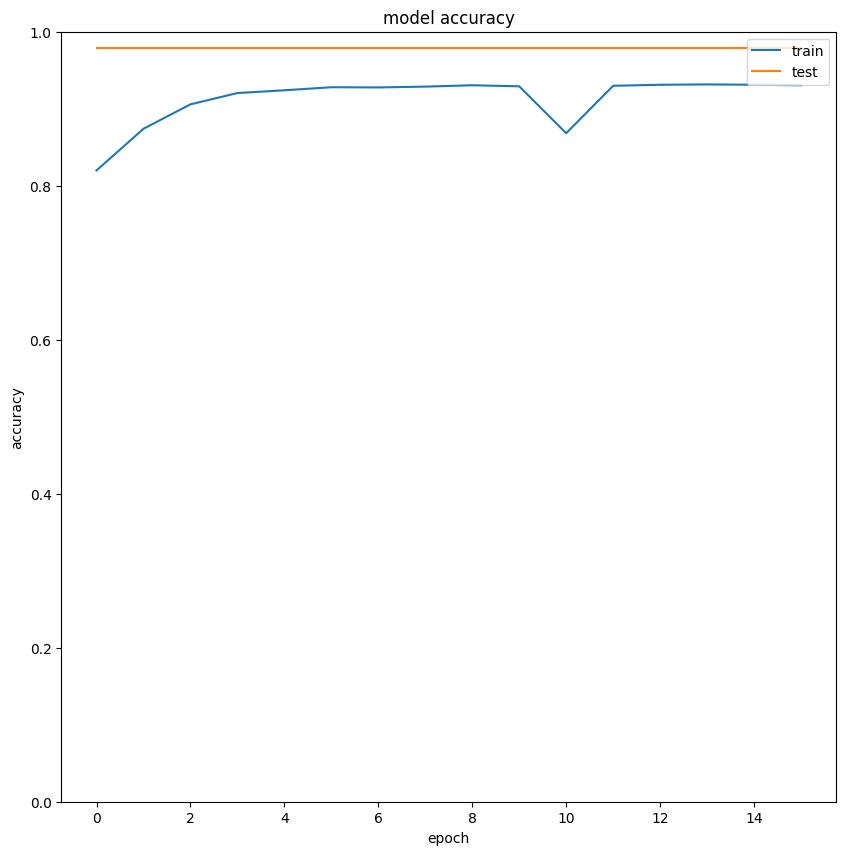

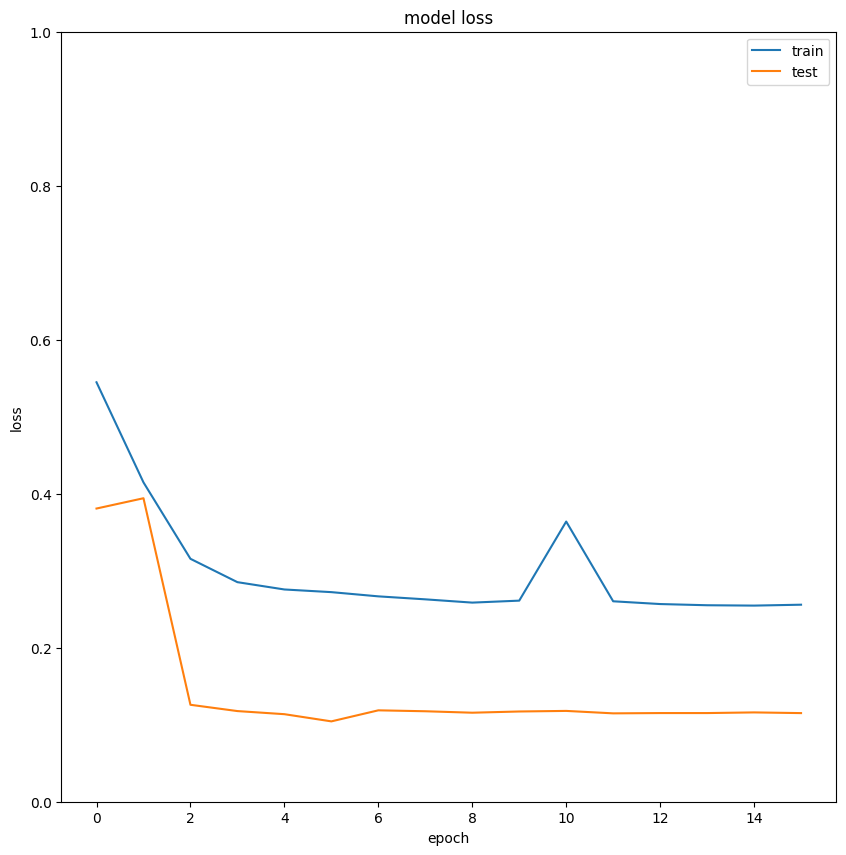

In [48]:
 #summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
fig_acc.savefig("LSTM_accuracy1.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='upper right')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

# 6.e. Padding


In [49]:
# add pad_sequences on the input sequences
N=18
x2_test_pd = np.append(np.zeros((N,13)), x2_test, axis=0)
y2_test_pd = np.append(np.zeros((N,)), encoded_y2_test, axis=0)
print(x2_test_pd.shape )
print(y2_test_pd.shape )

(12544, 13)
(12544,)


In [51]:
# creating val_arrays, and val_labs 
val_arrays = np.zeros((len(x2_test_pd),seq_length,13))
val_labs = np.zeros((len(y2_test_pd),))

#  loop to create the validation and ground truth
for i in range(2,len(x2_test_pd)-(seq_length+1)):
    val_arrays[i] = x2_test_pd[i:i+seq_length,:]
    val_labs[i] = y2_test_pd[i+20]    
print(val_arrays.shape)
print(val_labs.shape)

(12544, 20, 13)
(12544,)


# 6.f. Model Fitting and Plotting of the Prediction and Truth

392/392 [==============================] - 1s 1ms/step
Accuracy 0.9172512755102041


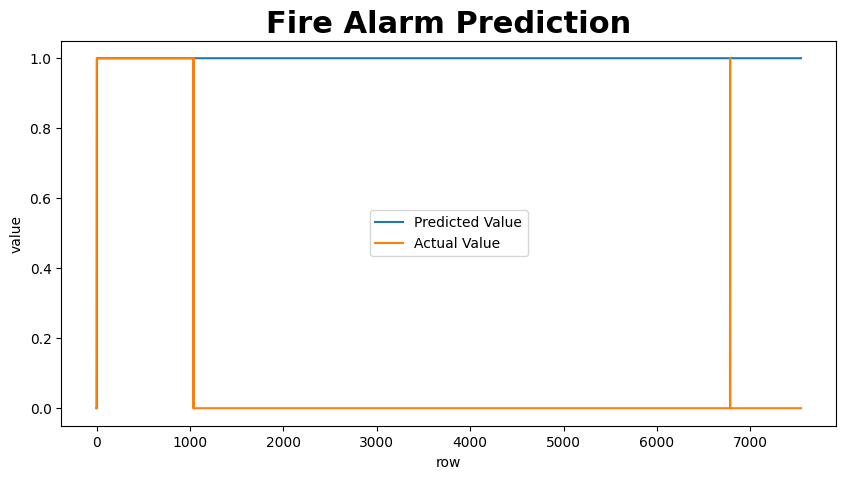

In [52]:
# To generate a binary output from the model, we will compare the output of the LSTM model to a threshold. 
# The threshold will maximize the accuracy similar to the threshold in binary classification in the Stat&Prob course
Threshold=0.9
y_true_test = val_labs
y_pred_test = model.predict(val_arrays) >Threshold

y_true_test = val_labs

scores_test = sum(y_pred_test[0]==y_true_test)/len(y_true_test)

print('Accuracy',scores_test)

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[0:-5000], label = 'Predicted Value')
plt.plot(y_true_test[0:-5000], label = 'Actual Value')
plt.title('Fire Alarm Prediction', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

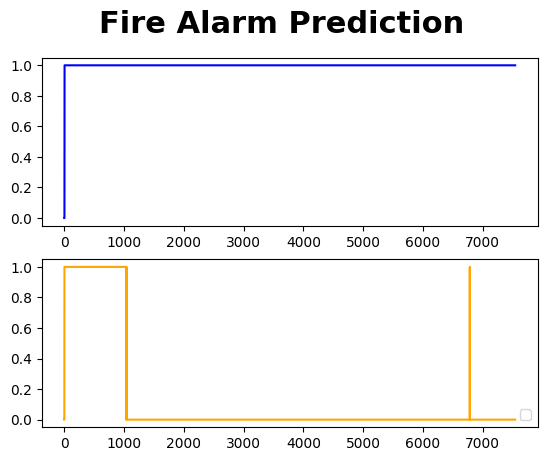

In [53]:
# subplotting the prediction and truth separately
fig, axis = plt.subplots(2)
figsize=(10,10)
fig.suptitle('Fire Alarm Prediction', fontsize=22, fontweight='bold')
l1= axis[0].plot(y_pred_test[0:-5000], label='Predicted', color='blue')
l2= axis[1].plot(y_true_test[0:-5000], label='True', color='orange')
plt.legend([l1, l2],['Predicted', 'Actual Value'], loc='lower right')
plt.show()


The accuracy results on the validation dataset is 91.7% which is a high accuracy. We see from the figure that the predicted values follow the trend of the actual values, except for a few errors which correspond to the 8.3% error.

In [54]:
# save prediction to csv file
## convert your array into a dataframe
prediction_LSTM_Fire_Alarm  = pd.DataFrame (y_pred_test)

## save to csv file

filepath = 'prediction_lstm_FA.csv'

prediction.to_csv(filepath, index=False)

## References

1. Fire death and injury risk. U.S. Fire Administration. (2022, September 21). Retrieved February 19, 2023, from https://www.usfa.fema.gov/statistics/deaths-injuries/ 
2. How do smoke detectors work? (2022, March 2). NIST. Retrieved February 19, 2023, from https://www.nist.gov/how-do-you-measure-it/how-do-smoke-detectors-work
3. Zach, How to Test for Multicollinearity in Python. (2022, October 12). STATLOGY. Retrieved February 19, 2023 from https://www.statology.org/multicollinearity-in-python/